In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
import tensorflow as tf
import tensorflow.keras as tfk

# Environment

In [3]:
class Environment:
    '''
        Simple environment
    '''
    def __init__(self, length = 100, normalize = True, noise = True, data = []):
        self.length = length

        if len(data) == 0:
            # self.data = -pd.DataFrame(np.arange(self.length))
            self.data = pd.DataFrame(np.sin(np.arange(length)/30.0))
        else:
            self.data = data

        if noise:
            self.data += pd.DataFrame(np.random.normal(0, 0.1, size=(length, )))

        if normalize:
            self.data = (self.data - self.data.min()) / (self.data.max() - self.data.min())

    def get_state(self, time, lookback, diff = True):
        window = self.data.iloc[time-lookback:time]
        if diff: window = window.diff().fillna(0.0)
        return window

    def get_reward(self, action, action_time, reward_time, coef = 100):
        # 0 => long; 1 => hold, 2 => short
        if action == 0:
            action = 1
        elif action == 1:
            action = 0
        else:
            action = -1
        price_now = self.data.iloc[action_time]
        price_reward = self.data.iloc[reward_time]
        price_diff = (price_reward - price_now) / price_now
        reward = np.sign(price_diff) * action * coef

        return reward.values.tolist()[0]

In [4]:
lin_env = Environment()

In [5]:
lin_env.get_state(10, 5, True)

,0
5,0.000000
6,0.044835
7,0.082256
8,0.037884
9,-0.045108


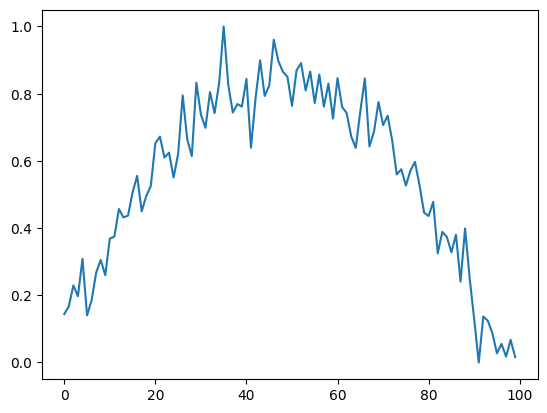

In [6]:
plt.figure()
plt.plot(lin_env.data)
plt.show()

In [7]:
lin_env.get_reward(0, 50, 51)

100.0

# Agent

In [8]:
import collections

In [9]:
class BuyHoldSellAgent:
    '''
        A simple agent
    '''
    def __init__(self, state_shape = 10, action_shape = 3, experience_size = 100):
        self.state_shape = state_shape
        self.action_shape = action_shape
        self.experience_size = experience_size
        self.model = self.init_model()
        self.experience = collections.deque(maxlen=self.experience_size)

    def init_model(self):
        inputs = tfk.Input(shape=(self.state_shape,))
        x = tfk.layers.Dense(10, activation='relu')(inputs)
        outputs = tfk.layers.Dense(self.action_shape, activation='linear')(x)
        model = tfk.Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer=tfk.optimizers.Adam(0.1), loss='mse', metrics='mse')
        return model

    def save_experience(self, state_i, q_value_i, action_i, reward_i, state_i_1):
        self.experience.append({
            'state_i': state_i,
            'q_value_i': q_value_i,
            'action_i': action_i,
            'reward_i': reward_i,
            'state_i_1': state_i_1
        })

    def replay_experience(self, alpha, gamma, sample_size):
        X, Y = [], []
        indices_sampled = np.random.choice(len(self.experience), sample_size, replace=False)
        for i, e in enumerate(self.experience):
            if i in indices_sampled:
                state_i, action_i, reward_i, q_value_i = e['state_i'], e['action_i'], e['reward_i'], e['q_value_i']
                state_i_1 = e['state_i_1']
                q_value_i_1 = self.model.predict(np.expand_dims(state_i_1, 0))[0]
                y_i = np.zeros(self.action_shape)
                y_i[:] = q_value_i[:]
                y_i[action_i] = (1 - alpha) * y_i[action_i] + alpha * (reward_i + gamma * max(q_value_i_1))
                X.append(state_i)
                Y.append(y_i)
        X, Y = np.array(X), np.array(Y)
        self.model.fit(X, Y, epochs=1, batch_size=sample_size, verbose=0, shuffle=True)

    def get_value_action_value(self, state):
        pred = self.model.predict(np.expand_dims(state, 0))
        return pred.flatten()

In [14]:
agent = BuyHoldSellAgent()

In [15]:
agent.get_value_action_value(
    pd.DataFrame(np.array(range(10)))
)

1/1 [==============================] - 0s 44ms/step


array([-1.1281554, -4.134055 ,  1.3354135], dtype=float32)

# Training

In [16]:
epochs = 5
gamma = 0.9
epsilon = 0.95
alpha = 0.9

In [17]:
DATASET_LENGTH = 250
WINDOW_SHAPE = 5
REWARD_TIME = 1
ACTIONS_SHAPE = 3
SAMPLE_SIZE = 16

In [18]:
environment = Environment(DATASET_LENGTH, True, False)
agent = BuyHoldSellAgent(WINDOW_SHAPE, ACTIONS_SHAPE)

In [ ]:
for i in range(epochs):

    learning_progress = []
    for j in range(WINDOW_SHAPE, DATASET_LENGTH - REWARD_TIME, REWARD_TIME):  #  generate range of values starting from WINDOW_SHAPE and ending at (DATASET_LENGTH - REWARD_TIME) , with step size REWARD_TIME

        # 1. getting current state
        state_j = environment.get_state(j, WINDOW_SHAPE)
        q_value_j = agent.get_value_action_value(state_j)

        # 2. acting in this state
        # Exploration
        if (np.random.random() < epsilon):
            action = np.random.randint(0, ACTIONS_SHAPE)
        # Exploitation
        else:
            action = (np.argmax(q_value_j))

        # 3. getting reward from this action
        reward_value_j = environment.get_reward(action, j, j+REWARD_TIME)
        learning_progress.append(reward_value_j)

        # 4. getting next state and value there
        state_j_1 = environment.get_state(j+1, WINDOW_SHAPE)

        # 5. save this experience
        agent.save_experience(state_j, q_value_j, action, reward_value_j, state_j_1)

        if j > SAMPLE_SIZE * 2:
            # 6. train on samples from experience
            agent.replay_experience(alpha, gamma, SAMPLE_SIZE)

    if epsilon > 0.1:
        epsilon -= (1.0/epochs)

    print('Epoch', i, '...', np.mean(learning_progress))
    learning_progress = []

# Evaluation

In [20]:
action_to_backtest_action = {
    0: 1,
    1: 0,
    2: -1
}

### Same dataset

In [21]:
actions = []
for j in range(WINDOW_SHAPE, DATASET_LENGTH, REWARD_TIME):
    state_j = environment.get_state(j, WINDOW_SHAPE)
    q_value_j = agent.get_value_action_value(state_j)
    actions.append(action_to_backtest_action[np.argmax(q_value_j)])

1/1 [==============================] - 0s 31ms/step


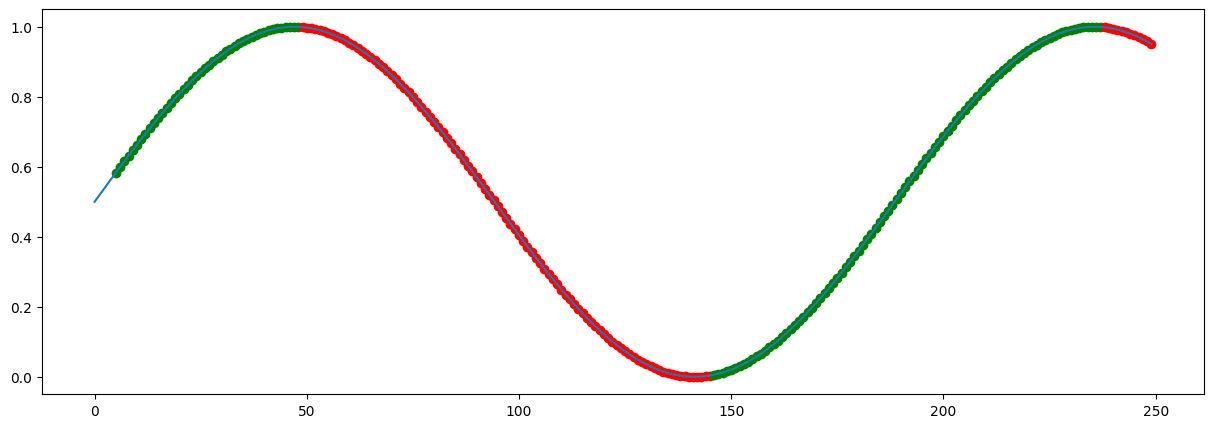

In [22]:
plt.figure(figsize = (15, 5))
plt.plot(environment.data)
for e, a in enumerate(actions):
    e += WINDOW_SHAPE
    if a == 1:
        plt.scatter(e, environment.data.iloc[e], color = 'green')
    elif a == -1:
        plt.scatter(e, environment.data.iloc[e], color = 'red')
    else:
        pass
plt.show()

<Axes: >

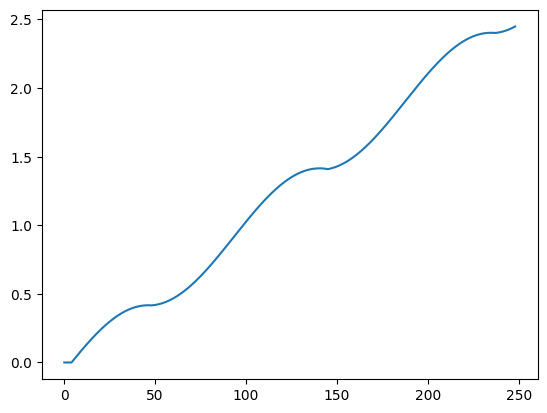

In [23]:
backtest = pd.DataFrame({
    'price': environment.data.values.flatten(),
    'signal': [0] * WINDOW_SHAPE + actions
})
backtest['price_diff'] = backtest['price'].diff().shift(-1)
(backtest['price_diff'] * backtest['signal']).cumsum().plot()

In [28]:
set(actions)

{-1, 1}

### Noisy dataset

In [ ]:
environment2 = Environment(DATASET_LENGTH, True, True)
actions = []
for j in range(WINDOW_SHAPE, DATASET_LENGTH, REWARD_TIME):
    state_j = environment2.get_state(j, WINDOW_SHAPE)
    q_value_j = agent.get_value_action_value(state_j)
    actions.append(action_to_backtest_action[np.argmax(q_value_j)])

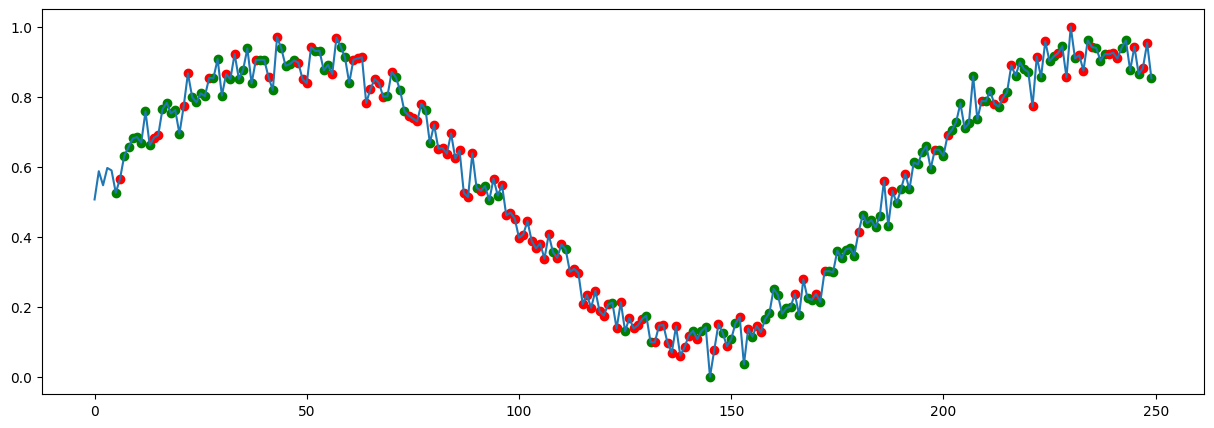

In [30]:
plt.figure(figsize = (15, 5))
plt.plot(environment2.data)
for e, a in enumerate(actions):
    e += WINDOW_SHAPE
    if a == 1:
        plt.scatter(e, environment2.data.iloc[e], color = 'green')
    elif a == -1:
        plt.scatter(e, environment2.data.iloc[e], color = 'red')
    else:
        pass
plt.show()

<Axes: >

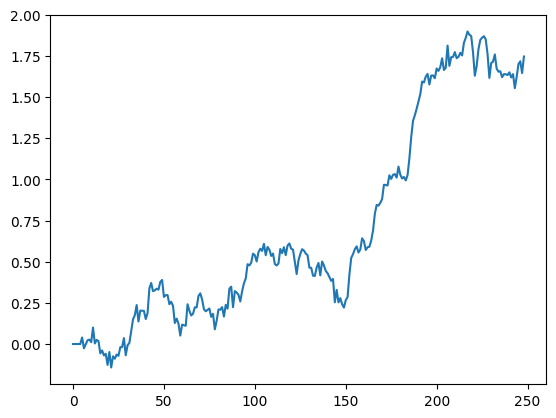

In [31]:
backtest = pd.DataFrame({
    'price': environment2.data.values.flatten(),
    'signal': [0] * WINDOW_SHAPE + actions
})
backtest['price_diff'] = backtest['price'].diff().shift(-1)
(backtest['price_diff'] * backtest['signal']).cumsum().plot()

### Other function

In [32]:
data_new = pd.DataFrame(
    np.cos(np.arange(DATASET_LENGTH)/5.0) +
    np.cos(np.arange(DATASET_LENGTH)/10) +
    np.cos(np.arange(DATASET_LENGTH)/20) +
    np.cos(np.arange(DATASET_LENGTH)/30)
    )

In [35]:
data_new.describe()

,0
count,250.000000
mean,0.093656
std,1.330828
min,-2.646130
25%,-0.851601
50%,0.053003
75%,0.594200
max,4.000000


In [ ]:
environment3 = Environment(DATASET_LENGTH, True, True, data_new)
actions = []
for j in range(WINDOW_SHAPE, DATASET_LENGTH, REWARD_TIME):
    state_j = environment3.get_state(j, WINDOW_SHAPE)
    q_value_j = agent.get_value_action_value(state_j)
    actions.append(action_to_backtest_action[np.argmax(q_value_j)])

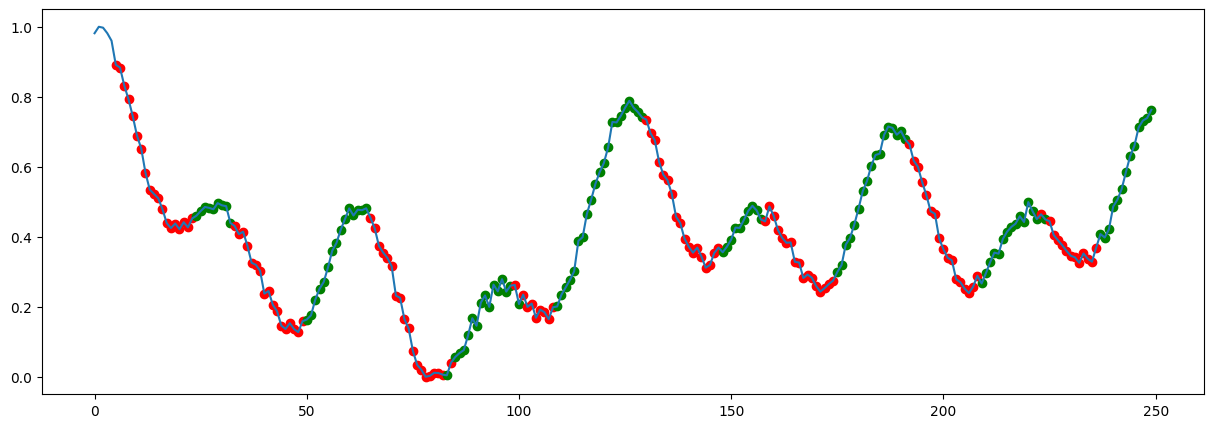

In [37]:
plt.figure(figsize = (15, 5))
plt.plot(environment3.data)
for e, a in enumerate(actions):
    e += WINDOW_SHAPE
    if a == 1:
        plt.scatter(e, environment3.data.iloc[e], color = 'green')
    elif a == -1:
        plt.scatter(e, environment3.data.iloc[e], color = 'red')
    else:
        pass
plt.show()

<Axes: >

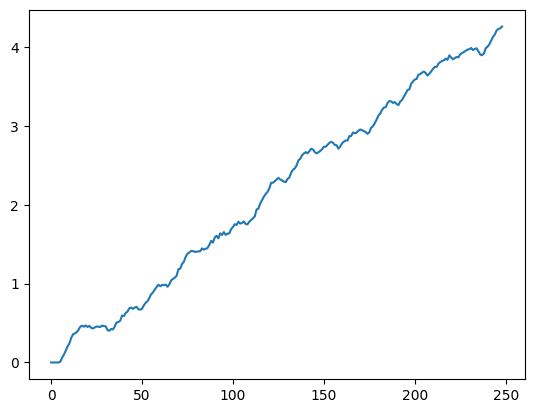

In [38]:
backtest = pd.DataFrame({
    'price': environment3.data.values.flatten(),
    'signal': [0] * WINDOW_SHAPE + actions
})
backtest['price_diff'] = backtest['price'].diff().shift(-1)
(backtest['price_diff'] * backtest['signal']).cumsum().plot()

In [39]:
from PIL import Image
import glob

In [40]:
! rm -rf forgif
! mkdir forgif

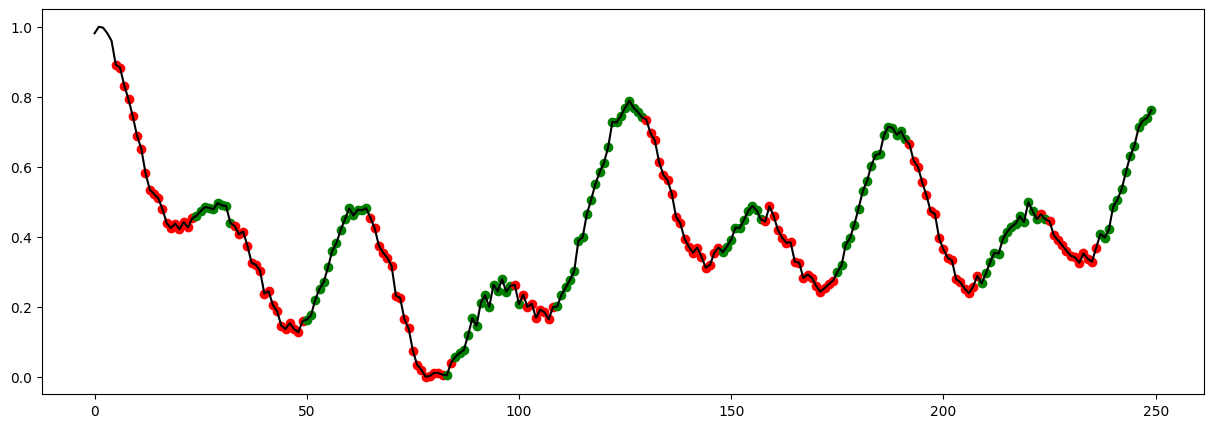

In [41]:
plt.figure(figsize = (15, 5))
plt.plot(environment3.data, color = 'black')
for e, a in enumerate(actions):
    e += WINDOW_SHAPE
    if a == 1:
        plt.scatter(e, environment3.data.iloc[e], color = 'green')
    elif a == -1:
        plt.scatter(e, environment3.data.iloc[e], color = 'red')
    else:
        pass
    plt.savefig('./forgif/i_' + str(e).zfill(4) + '.jpg')

In [ ]:
frames = []
imgs = glob.glob("./forgif/*.jpg")
frames = [Image.open(i) for i in sorted(imgs)]

In [ ]:
# Save into a GIF file that loops forever
frames[0].save(
    'png_to_gif.gif', format='GIF',
    append_images=frames[1:],
    save_all=True,
    duration=100, loop=0)